## Thermal Conductivity Fit Analysis
### Developed by Henry Nachman
#### Last Edited: 23 January 2024

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import h5py
import sys

First, we need to find where all our RAW data is

In [2]:
path_to_lib = f"{os.getcwd()}\\lib"
mat_directories = [folder for folder in os.listdir(path_to_lib) if not folder.endswith(".md")]

path_to_RAW = dict()
for mat in mat_directories:
    raw_str = f"{path_to_lib}\\{mat}\\RAW"
    path_to_RAW[mat] = raw_str


print(path_to_RAW)

{'SS304': 'c:\\Users\\henac\\OneDrive - The University of Texas at Austin\\01_RESEARCH\\05_CMBS4\\Cryogenic_Material_Properties\\thermal_conductivity\\lib\\SS304\\RAW', 'SS305': 'c:\\Users\\henac\\OneDrive - The University of Texas at Austin\\01_RESEARCH\\05_CMBS4\\Cryogenic_Material_Properties\\thermal_conductivity\\lib\\SS305\\RAW'}


Next, we need to extract each file.

In [3]:
def get_datafiles(raw_path):
    all_files = os.listdir(raw_path)
    extension = ".csv"
    raw_files = [file for file in all_files if file.endswith(extension)]
    print(f"Found {len(raw_files)} measurements.")
    return raw_files

In [4]:
def parse_raw(material_name, path_dict):
    raw_directory = path_dict[material_name]
    all_files = os.listdir(raw_directory)
    extension = ".csv"
    raw_files = [file for file in all_files if file.endswith(extension)]
    
    big_data = np.empty((0,3), float)
    data_dict = dict()
    for f in raw_files:
        f_path = raw_directory +"\\"+ f
        file1 = np.loadtxt(f_path, dtype=str, delimiter=',')
        ref_row = file1[0]
        ref_name = f[:-4]
        raw_data = np.array(file1[2:,:], dtype=float)
        big_data = np.append(big_data, raw_data, axis=0)
        data_dict[ref_name] = raw_data
        T, k, koT = raw_data.T

        plt.plot(T, k, '.', label=ref_name)
    plt.legend()
    plt.xlabel("Temperature")
    plt.ylabel("k")
    plt.semilogx()
    plt.semilogy()
    plt.savefig(f"{os.path.split(raw_directory)[0]}\\{material_name}.pdf", dpi=300, format="pdf")
    plt.show()
    plt.clf()

    return big_data, data_dict

In [5]:
def fit_thermal_conductivity(big_data, save_path, thresh = 20, fit_orders = (2,3), fit_types=("k/T", "loglog"), plots=False):
    # thresh     : 20    : The temperature threshold to split low and high data   
    # fit_orders : (2,3) : The polynomial order for the low and high fits respectively

    # divide the data array into three columns
    T = big_data[:,0]
    k = big_data[:,1]
    koT = big_data[:,2]

    # Set a temperature threshold for split between hi and low fits
    thresh = 20 # in K

    # Find the low range
    lowT = T[T<thresh]
    lowT_k = k[T<thresh]
    lowT_koT = koT[T<thresh]

    # Find the high range
    hiT = T[T>thresh]
    hiT_k = k[T>thresh]
    # Take a log10 of the high range
    log_hi_T = np.log10(hiT)
    log_hi_k = np.log10(hiT_k)

    # Fit the low data
    if fit_types[0] == "k/T":
        low_fit = np.polyfit(lowT, lowT_koT, fit_orders[0])
        low_fit_xs = np.linspace(np.min(lowT), np.max(lowT), 100)
        low_poly1d = np.poly1d(low_fit)


    # Fit the high data
    if fit_types[1] == "loglog":
        hi_fit = np.polyfit(log_hi_T, log_hi_k, fit_orders[1])
        hi_fit_xs = np.linspace(np.min(log_hi_T), np.max(log_hi_T), 100)
        hi_poly1d = np.poly1d(hi_fit)


    if plots:
        fig, axs = plt.subplots(2, figsize=(8, 6))
        axs[0].plot(lowT, lowT_koT,'.')
        axs[0].plot(low_fit_xs, np.polyval(low_fit, low_fit_xs))
        axs[0].set_xlabel("T")
        axs[0].set_ylabel("k/T")
        axs[0].title.set_text("Low Temperature Fit")
        # axs[1].plot(hi_fit_xs, np.polyval(hi_fit, hi_fit_xs))
        # axs[1].plot(log_hi_T, log_hi_k, '.')
        axs[1].loglog(10**hi_fit_xs, 10**np.polyval(hi_fit, hi_fit_xs))
        axs[1].loglog(hiT, hiT_k, '.')
        axs[1].grid(True, which="both", ls="-", color='0.65')
        axs[1].set_ylabel("k")
        axs[1].set_xlabel("T")
        axs[1].title.set_text("High Temperature Fit")
        plt.subplots_adjust(wspace=0.4, hspace=0.4)
        plt.savefig(f"{save_path}\\fitPlot.pdf", dpi = 300, format="pdf")
        plt.show()
        plt.clf()
        
    low_func = f"{fit_orders[0]} order {fit_types[0]}"
    hi_func = f"{fit_orders[1]} order {fit_types[1]}"
    
    arg_dict = {"low_function_type"  : low_func,
                "low_fit_param"      : np.array(low_fit).tolist(),
                "low_fit_range"      : np.array([min(low_fit_xs), max(low_fit_xs)]).tolist(),
                "hi_function_type"   : hi_func,
                "hi_fit_param"  : np.array(hi_fit).tolist(),
                "hi_fit_range"  : np.array([10**min(hi_fit_xs), 10**max(hi_fit_xs)]).tolist()}
    return arg_dict



In [6]:
import yaml

def make_fit_yaml(fit_args, save_path):
    with open(f"{save_path}\\{os.path.split(save_path)[1]}.yaml", 'w') as file:
        for key in fit_args.keys():
            yaml.dump(key, file)
            yaml.dump(np.array(fit_args[key]).tolist(), file)
    return

def make_fit_lh5(fit_args, save_path):
    comp_file = f"{save_path}\\{os.path.split(save_path)[1]}.lh5"
    with h5py.File(comp_file, "w") as f:
        for key in fit_args:
            f.create_dataset(f"{key}", data=fit_args[key])
    return comp_file

In [7]:
from cycler import cycler
def tk_plot(material_name, path_dict, data_dict, fit_args):
    raw_directory = path_dict[material_name]
    markers = ['o', 's', 'd', 'P','3', '*']
    i = 0
    for ref_name in data_dict.keys():
        T, k, koT = data_dict[ref_name].T
        plt.plot(T, k, marker=markers[i], ms=10, mfc='none', label=ref_name)
        i+=1
        if i == len(markers):
            i = 0
    low_xs = np.linspace(fit_args["low_fit_range"][0],fit_args["low_fit_range"][1],100)
    plt.plot(low_xs, low_xs*np.polyval(fit_args["low_fit_param"], low_xs), c='black')
    hi_xs = np.linspace(fit_args["hi_fit_range"][0],fit_args["hi_fit_range"][1],100)
    plt.plot(hi_xs, 10**np.polyval(fit_args["hi_fit_param"], np.log10(hi_xs)), c='black')
    plt.legend()
    plt.xlabel("Temperature")
    plt.ylabel("k")
    plt.semilogx()
    plt.semilogy()
    plt.savefig(f"{os.path.split(raw_directory)[0]}\\{material_name}_fit.pdf", dpi=300, format="pdf")
    plt.show()
    plt.clf()
    return

dict_keys(['SS304', 'SS305'])


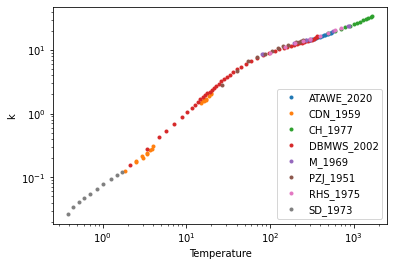

<Figure size 432x288 with 0 Axes>

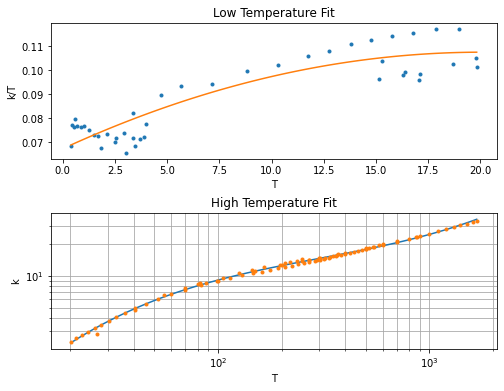

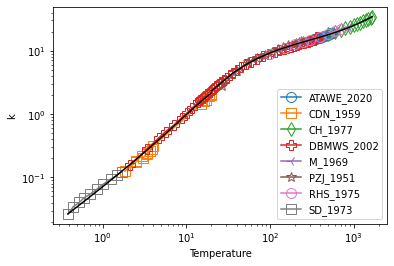

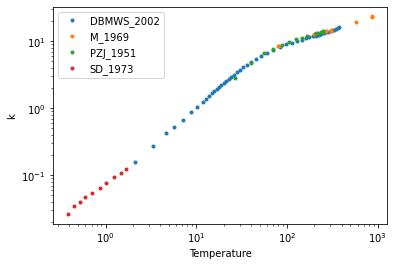

<Figure size 432x288 with 0 Axes>

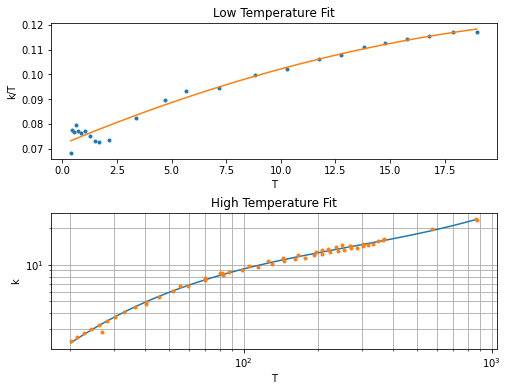

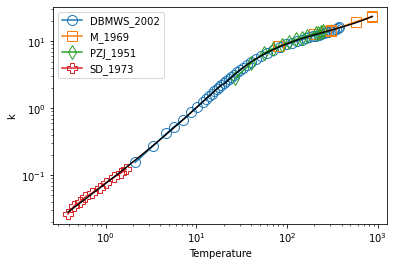

<Figure size 432x288 with 0 Axes>

In [8]:
print(path_to_RAW.keys())
for mat in path_to_RAW.keys():
    big_data, data_dict = parse_raw(mat, path_to_RAW)
    fit_args = fit_thermal_conductivity(big_data, os.path.split(path_to_RAW[mat])[0], plots=True)
    make_fit_yaml(fit_args, os.path.split(path_to_RAW[mat])[0])
    make_fit_lh5(fit_args, os.path.split(path_to_RAW[mat])[0])
    tk_plot(mat,path_to_RAW, data_dict, fit_args)